# Get B_NEC data at 10s sampling, residual to MCO_SHA_2C, for one day

In [1]:
from viresclient import SwarmRequest
import datetime as dt

request = SwarmRequest(url="https://staging.viresdisc.vires.services/openows")
request.set_collection("SW_OPER_MAGA_LR_1B")
request.set_products(measurements=["B_NEC"],
                     models=["MCO_SHA_2C"],
                     residuals=True,
                     sampling_step="PT10S")

data = request.get_between(start_time=dt.datetime(2016,1,1),
                           end_time=dt.datetime(2016,1,2))

ds = data.as_xarray()
ds

[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.497MB)


<xarray.Dataset>
Dimensions:               (Timestamp: 8640, dim: 3)
Coordinates:
  * Timestamp             (Timestamp) datetime64[ns] 2016-01-01 ...
Dimensions without coordinates: dim
Data variables:
    Spacecraft            (Timestamp) <U1 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' ...
    Latitude              (Timestamp) float64 -72.5 -73.13 -73.76 -74.39 ...
    Longitude             (Timestamp) float64 92.79 93.09 93.41 93.77 94.15 ...
    Radius                (Timestamp) float64 6.834e+06 6.834e+06 6.834e+06 ...
    B_NEC_res_MCO_SHA_2C  (Timestamp, dim) float64 -5.105 -185.2 -78.22 ...

# Use cartopy to plot the vertical component of the residual, over each polar region

Adapted from examples at https://scitools.org.uk/cartopy/docs/v0.15/gallery.html

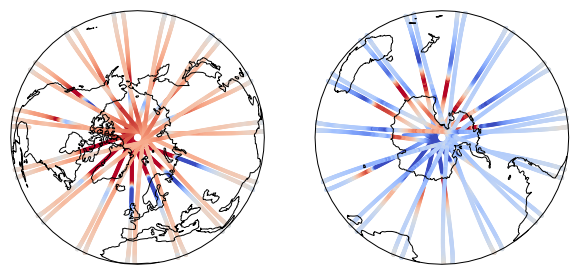

In [2]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
%matplotlib inline

def make_plot(ds, var, cmap=cm.coolwarm, norm=Normalize(vmin=-100,vmax=100)):

    fig = plt.figure(figsize=[10, 5])
    ax1 = plt.subplot(1, 2, 1, projection=ccrs.Orthographic(0, 90))
    ax2 = plt.subplot(1, 2, 2, projection=ccrs.Orthographic(180, -90))

    def plot_hs(ax, ds):
        ax.scatter(ds.Longitude, ds.Latitude, c=ds[var][:,2], transform=ccrs.PlateCarree(),
                      s=10, cmap=cmap, norm=norm)
        ax.set_global(); ax.coastlines();

    dsN = ds.where(ds["Latitude"] > 0)
    dsS = ds.where(ds["Latitude"] < 0)
    for ax, ds_subset in zip([ax1, ax2], [dsN, dsS]):
        plot_hs(ax, ds_subset)
    
    return fig

make_plot(ds, "B_NEC_res_MCO_SHA_2C");

There is a hemispheric bias because we haven't accounted for the magnetospheric field

# Redo the above, using MCO_SHA_2F and MMA_SHA_2F

In [3]:
request = SwarmRequest(url="https://staging.viresdisc.vires.services/openows")
request.set_collection("SW_OPER_MAGA_LR_1B")
request.set_products(measurements=["B_NEC"],
                     models=["MCO_SHA_2F", "MMA_SHA_2F-Primary", "MMA_SHA_2F-Secondary"],
                     sampling_step="PT10S")

data = request.get_between(start_time=dt.datetime(2016,1,1),
                           end_time=dt.datetime(2016,1,2))

[1/1] Processing:  100%|██████████|  [ Elapsed: 00:02, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (1.121MB)


Evaluate the custom residual $B_{res} = B_{obs} - B_{MCO (F)} - B_{MMA (F)}$ :

In [4]:
ds = data.as_xarray()
ds["Bres"] = ds["B_NEC"] - ds["B_NEC_MCO_SHA_2F"] \
                         - ds["B_NEC_MMA_SHA_2F-Primary"] \
                         - ds["B_NEC_MMA_SHA_2F-Secondary"]

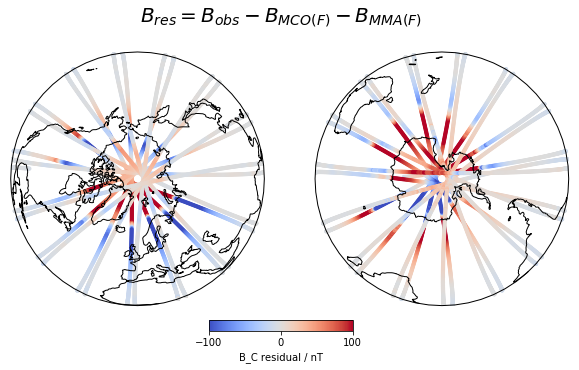

In [5]:
cmap = cm.coolwarm
norm = Normalize(vmin=-100,vmax=100)
fig = make_plot(ds, "Bres", cmap=cmap, norm=norm)

ax_d = fig.add_axes([0.4,0.08,0.2,0.03]) #[left, bottom, width, height] 
ColorbarBase(ax_d,cmap=cmap,norm=norm,orientation='horizontal', label="B_C residual / nT", ticks=[-100,0,100]);

fig.suptitle("$B_{res} = B_{obs} - B_{MCO (F)} - B_{MMA (F)}$", fontsize=20);

This shows the magnetic disturbance created around the auroral region during this day.

# Plot the same data as a time series

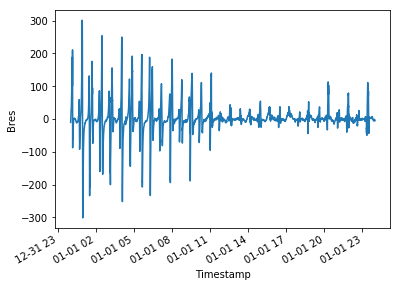

In [6]:
ds["Bres"][:,2].plot();

This shows the evolution of the disturbance with time.